# Pretraitement
Les fichiers utilisent l'extension `.json`, mais sont en fait une liste de dictionnaires python. Il est donc impossible de l'importer avec la librairie `json` puisque les dictionnaires python utilisent des `single quotes` et non des `double quotes` pout les clefs.  

Les fichiers doivent être convertis en csv pour faciliter leur usage avec Neo4j.  

Voici un exemple d'entré dans le fichier. :

In [ ]:
# Chaque ligne du fichier est un objet JSON sérialisé (un dict Python)

json_seq = {
    'user_id': '76561198215949741', 
    'items_count': 2, 
    'steam_id': '76561198215949741', 
    'user_url': 'http://steamcommunity.com/profiles/76561198215949741', 
    'items': [
        {
            'item_id': '730', 
            'item_name': 'Counter-Strike: Global Offensive', 
            'playtime_forever': 38830, 
            'playtime_2weeks': 1025
        },
        {
            'item_id': '236110', 
            'item_name': 'Dungeon Defenders II', 
            'playtime_forever': 23, 
            'playtime_2weeks': 23
        }
    ]
}

In [2]:
import pandas as pd
import numpy as np
import math

In [1]:
# Fonction pour importer les dictionnaires Python en liste

import ast

def import_python_dicts(filename, lines=None):
    dicts = []
    line_count = 0
    with open(filename, 'r') as file:
        for line in file:
            try:
                dictionary = ast.literal_eval(line.strip())
                dicts.append(dictionary)
            except (SyntaxError, ValueError) as e:
                print(f"Error parsing line: {line.strip()} - {e}")
            line_count += 1
            if lines == line_count:
                break
    return dicts

In [ ]:
items = import_python_dicts('./data/australian_users_items.json')
print('loaded', len(items), 'items')

## Games
On calcule le total de toutes les heures jouées et du nombre total de joueurs pour chaque jeu.    

Les clefs désirés : 
`game_id`, `name`, `temps_total_joué`, `nombre_joueurs_joué`  

In [ ]:
games = {}
time_played = {}
player_count = {}
all_times_played = {}

for user in items:
    for item in user['items']:
        games[item['item_id']] = item['item_name']
        if item['item_id'] not in time_played:
            time_played[item['item_id']] = item['playtime_forever']
        else:
            time_played[item['item_id']] += item['playtime_forever']
        
        # on ignore si le temps de jeu est de 0 pour un joueur
        if item['playtime_forever'] > 0:
            if item['item_id'] not in player_count:
                player_count[item['item_id']] = 1
            else:
                player_count[item['item_id']] += 1

            if item['item_id'] not in all_times_played:
                all_times_played[item['item_id']] = [item['playtime_forever']]
            else:
                all_times_played[item['item_id']].append(item['playtime_forever'])

Conversion des dictionnaires en DataFrame pour la sauvegarde en CSV.  
On calcul aussi d'autres métriques comme le temps joué médian.  
Pour réduire la grosseur de sauvegarde des fichiers, les temps sont convertis en heure à partir du temps en minutes.  

In [ ]:
games_df = pd.DataFrame(list(games.items()), columns=['game_id', 'name'])

for i, row in games_df.iterrows():
    games_df.at[i, 'time_played'] = math.ceil(time_played[row['game_id']] / 60) if row['game_id'] in time_played else 0
    games_df.at[i, 'player_count'] = player_count[row['game_id']] if row['game_id'] in player_count else 0
    games_df.at[i, 'median_time_played'] = math.ceil(sorted(all_times_played[row['game_id']])[len(all_times_played[row['game_id']]) // 2] / 60) if row['game_id'] in all_times_played else 0

games_df['time_played'] = games_df['time_played'].astype(int)
games_df['player_count'] = games_df['player_count'].astype(int)
games_df['median_time_played'] = games_df['median_time_played'].astype(int)
games_df.to_csv('./data_csv/games_data.csv', index=False)

In [48]:
# show max median time played with player count over 100
df_over_100 = games_df[games_df['player_count'] > 10]
max_median_time_played = df_over_100['median_time_played'].max()
print(df_over_100[df_over_100['median_time_played'] == max_median_time_played])


    game_id                              name  time_played  player_count  \
178     730  Counter-Strike: Global Offensive     13086405         43279   

     median_time_played  
178                 113  


## User lib  

Ici les manipulations sont plus simples. On ne fait que faire une entré par paire de joueur-jeu possédé. La conversion du temps en heure est aussi appliqué. Nous avons un champ du temps joué dans les deux derniéres semaines que nous simplifions pour indiquer si le joueur est actif à ce jeu.  

Voici les clef désirées : 
`user_id`, `game_id`, `playtime (hours)`, `active (bool)`

In [ ]:
users_games = []
for user in items:
    if user['items_count'] == 0:
        continue
    for item in user['items']:
        # if item['playtime_forever'] > 0:
        users_games.append({
            'user_id': user['user_id'],
            'game_id': item['item_id'],
            'playtime': math.ceil(item['playtime_forever'] / 60),
            'active': item['playtime_2weeks'] > 0
        })

In [16]:
users_games_df = pd.DataFrame(users_games)
users_games_df.to_csv('./data_csv/users_games.csv', index=False)

## User data

Ici nous sauvegardons l'information sur le joueur donc son jeu le plus joué à des fins de recommendation futures.  

Les clefs sont : 
`user_id`, `games_count`, `total_playtime`, `most_played_game_id`

In [49]:
users_data = []
for user in items:
    if user['items_count'] == 0:
        continue

    total_playtime = 0
    for item in user['items']:
        total_playtime += item['playtime_forever']

    played_games = len([item for item in user['items'] if item['playtime_forever'] > 0])
    
    # if total_playtime == 0:
    #     continue

    most_played_game = max(user['items'], key=lambda x: x['playtime_forever'])

    users_data.append({
        'user_id': user['user_id'],
        'items_count': user['items_count'],
        'played_games': played_games,
        'total_playtime': math.ceil(total_playtime / 60),
        'most_played_game_id': most_played_game['item_id'],
    })

In [50]:
users_data_df = pd.DataFrame(users_data)
users_data_df.to_csv('./data_csv/users_data.csv', index=False)

## Calculer des bins  

Afin de guider la recommendation, nous avons diviser le nombre d'heures joué en 5 bins égales contenant le même nombre de joueurs. Il est donc possible de voir, par le nombre d'heures joué, si un joueur est un super-joueur ou non.  

Un graphique plus bas montre la distribution du nombre d'heure de `Sid Meier's Civilization V` par tous ses joueurs. 

In [2]:
user_games_df = pd.read_csv('./data_csv/users_games.csv')
games_df = pd.read_csv('./data_csv/games_data.csv')

In [3]:
games_bins = {}

for _, game in games_df.iterrows():
    game_id = game['game_id']
    playtime = user_games_df[user_games_df['game_id'] == game_id]['playtime']
    bin_edges = np.percentile(playtime, np.linspace(0, 100, 6)).astype(int).tolist()[1:]
    games_bins[game_id] = bin_edges

col_names = ['max_bin_1', 'max_bin_2', 'max_bin_3', 'max_bin_4', 'max_bin_5']
# add to games_df
for i, row in games_df.iterrows():
    game_id = row['game_id']
    bins = games_bins[game_id]
    for j, bin_edge in enumerate(bins):
        games_df.at[i, col_names[j]] = bin_edge

for col in col_names:
    games_df[col] = games_df[col].astype(int)

games_df.to_csv('./data_csv/games_data_bins.csv', index=False)

[1, 8, 24, 56, 128, 7091]


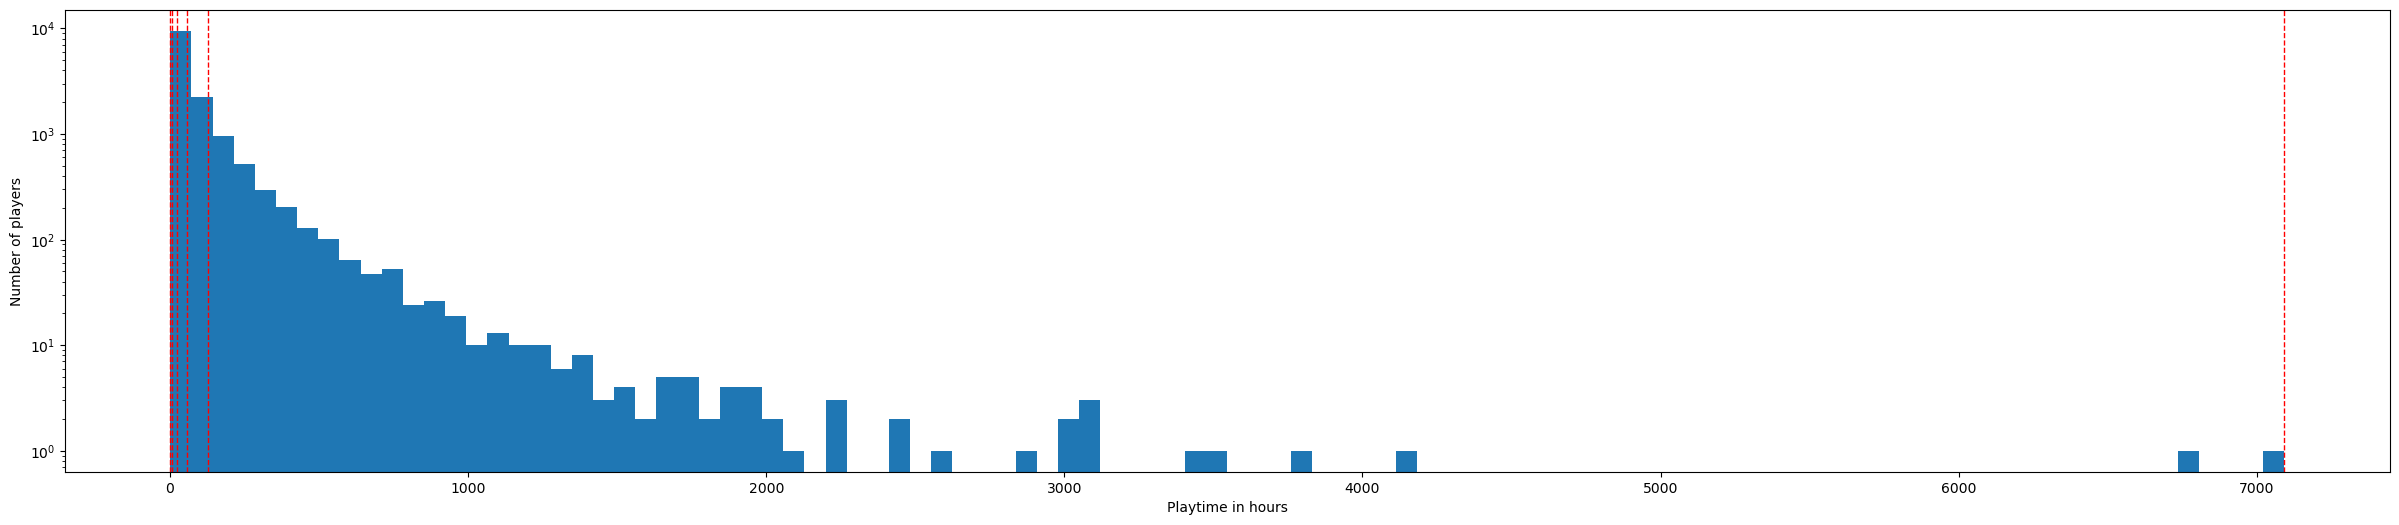

In [7]:
import matplotlib.pyplot as plt

# cs_go = user_games_df[user_games_df['game_id'] == 730]
users_playtime = user_games_df[user_games_df['game_id'] == 8930]
# remove 0
users_playtime = users_playtime[users_playtime['playtime'] > 0]

playtime = users_playtime['playtime']
num_bins = 5

# pour avoir des bins de même taille (meme nombre de joueurs dans chaque bin)
bin_edges = np.percentile(playtime, np.linspace(0, 100, num_bins + 1)).astype(int).tolist()
print(bin_edges)

plt.figure(figsize=(30, 6))
plt.hist(users_playtime['playtime'], bins=100, log=True)
plt.xlabel('Playtime in hours')
plt.ylabel('Number of players')
for edge in bin_edges:
    plt.axvline(edge, color='r', linestyle='dashed', linewidth=1)
plt.show()

## Réduire les données inutiles  

Après avoir traité les données, nous avons réalisé qu'elles étaient trop massives pour Neo4j avec nos ordinateurs personnels. Nous avons donc retirés les données que nous considérons inutiles. Nous avons ainsi réduit de presque moitié le nombre d'entrées, réduisant aussi significativement le nombre de liens dans Neo4j. 

In [ ]:
# Trouver les mauvais jeux (moins de 100 joueurs ou median time played <= 1)

games = pd.read_csv('./data_csv/games_data.csv')
few_players = games[games['player_count'] < 100]
poor_playtime = games[games['median_time_played'] <= 1]
few_players = pd.concat([few_players, poor_playtime])
few_players = few_players.drop_duplicates()
print(len(few_players)) # nombre de mauvais jeux
few_players = few_players['game_id']
few_players.to_csv('./data_csv/few_players.csv', index=False)

9124


In [ ]:
# Retirer les mauvais jeux des données des utilisateurs

users_games = pd.read_csv('./data_csv/users_games.csv')
poor_games = pd.read_csv('./data_csv/few_players.csv')
users_games = users_games[users_games['playtime'] >= 1]
users_games = users_games[~users_games['game_id'].isin(poor_games['game_id'])]
users_games.to_csv('./data_csv/good_games/users_games.csv', index=False)

In [ ]:
# Retirer les mauvais jeux des données des jeux

poor_games = pd.read_csv('./data_csv/few_players.csv')
games = pd.read_csv('./data_csv/games_data_bins.csv')
games = games[~games['game_id'].isin(poor_games['game_id'])]
games.to_csv('./data_csv/good_games/games_data_bins.csv', index=False)

In [ ]:
# Retirer les mauvais jeux des données des reviews

aus_reviews = pd.read_csv('./data_csv/aus_reviews.csv')
poor_games = pd.read_csv('./data_csv/few_players.csv')
aus_reviews = aus_reviews[~aus_reviews['item_id'].isin(poor_games['game_id'])]
aus_reviews.to_csv('./data_csv/good_games/aus_reviews.csv', index=False)